# Network Soothing and Gravity Models
The file concentrated on conducting the network smoothing and used the gravity model to capture the interactions, the file includes three parts:
- Part1: find the best parameter set of alpha in network smoothing
- Part2: make the plot between alpha and targeted interactions
- Part3: use the best alpha to calculate the gravity and other information 

import the environment and dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")

In [64]:
df_gl_S1 = pd.read_csv(r'Dataset/S1_gl_cs_400.csv')
df_ei_S1 = pd.read_csv(r'Dataset/S1_ei_cs_400.csv')

df_gl_S2 = pd.read_csv(r'Dataset/S2_gl_cs_400.csv')
df_ei_S2 = pd.read_csv(r'Dataset/S2_ei_cs_400.csv')

df_gl_S3 = pd.read_csv(r'Dataset/S3_gl_cs_400.csv')
df_ei_S3 = pd.read_csv(r'Dataset/S3_ei_cs_400.csv')

df_gl_S4 = pd.read_csv(r'Dataset/S4_gl_cs_400.csv')
df_ei_S4 = pd.read_csv(r'Dataset/S4_ei_cs_400.csv')
driver_list = pd.read_csv(r'canonical_drivers.txt')
driver_list = list(driver_list['driver gene symbol'])

- Functions and Tools:

get_neigbors: get the neighbors of each node and return a dict

In [3]:
import networkx as nx
def get_neigbors(g, node, depth=1):
    output = {}
    layers = dict(nx.bfs_successors(g, source=node, depth_limit=depth))
    nodes = [node]
    for i in range(1,depth+1):
        output[i] = []
        for x in nodes:
            output[i].extend(layers.get(x,[]))
        nodes = output[i]
    return output

k_neighbour_cw: the network smoothing, but just calculate the propagated weight on each node

In [4]:
def k_neighbour_cw(df_gl,list_dgr,dict_neighbour,gene_list):
    df_gl = pd.concat([df_gl,pd.DataFrame(columns=['Pmutation'])])
    cw = []
    for i in range(len(df_gl)):
        cw.append(0)
    j = 0
    for key,value in dict_neighbour.items():
        if(j%700) == 0:
            print(j)
        mc_key = df_gl['mutation_count'].loc[gene_list.index(key)]
        if mc_key != 0:
            dgr_key = list_dgr[gene_list.index(key)]
            for k,v in value.items():
                gb_value = mc_key * (1/(math.factorial(k) * dgr_key))
                for item in v:
                    cw[gene_list.index(item)] = cw[gene_list.index(item)] + gb_value
        j = j + 1
    df_gl['Pmutation'] = cw
    return df_gl

compute_G: calculate the gravity on the smoothed network

In [45]:
def compute_G(df_gl,df_ei,n):
    gA = list(df_ei['geneA'])
    gB = list(df_ei['geneB'])
    pclist = list(df_ei['pearson correlation coefficient'])
    M_list = list(df_gl['Pt1'])
    gene_list = list(df_gl['gene_symbol'])
    df_ei = pd.concat([df_ei,pd.DataFrame(columns=['gravity','G_type'])])
    
    gravity = []
    gtype = []
    g_dict = {}
    for i in range(len(df_ei)):
        g1 = gA[i]
        g2 = gB[i]
        pcc = pclist[i]
        # Some gene names contain '-', and the keyname use '===' to connect two genes
        kname = g1+'==='+g2
        
        M1_p = M_list[gene_list.index(g1)]
        M2_p = M_list[gene_list.index(g2)]
        G = M1_p*M2_p/(1/pcc*pcc)
        gravity.append(G)
        if pcc > 0:
            g_dict[kname] = G
            gtype.append('AG')
        elif pcc < 0:
            g_dict[kname] = G*-1
            gtype.append('RG')
    df_ei['gravity'] = gravity
    df_ei['G_type'] = gtype
    # normalization：
    from sklearn import preprocessing
    gravity.sort(reverse=True)
    gvt2 = preprocessing.minmax_scale(gravity)
    
    for i in range(0,n):  
        # print TopN interactions
        klist = []
        vlist = []
        #print(str(i+1)+":")
        for key,value in g_dict.items():
            if value == gravity[i]:
                klist.append(key)
                vlist.append(value)
        for j in range(len(vlist)):
            print(klist[j],end=" ")
            print(gvt2[i],end=" ")
            if vlist[j] > 0:
                print("AG")
            elif vlist[j] < 0:
                print("RG")
    return df_ei

compute_sumG: calculate the sumG of each gene in the high gravity networks

In [46]:
def compute_sumG(df_ei,df_gl,gene_list):
    dict_gravity = {}
    for item in gene_list:
        dict_gravity[item] = []
    # 遍历df_ei：
    for i in range(len(df_ei)):
        gravity = df_ei['gravity'].loc[i]
        gA = df_ei['geneA'].loc[i]
        gB = df_ei['geneB'].loc[i]
        dict_gravity[gA].append(gravity)
        dict_gravity[gB].append(gravity)
    df_gl = pd.concat([df_gl,pd.DataFrame(columns=['sumG'])])
    for i in range(len(df_gl)):
        df_gl['sumG'].loc[i] = sum(dict_gravity[df_gl['gene_symbol'].loc[i]])
    return df_gl

initial: the integerated function for identifying the best parameter of alpha, also get the final results

In [115]:
def initial(alpha,df_gl,df_ei,resultsize):
    print("alpha=" + str(alpha))
    pm = list(df_gl['Pmutation'])
    # 归一化Pmutation：
    pm_max = max(pm)
    pm_min = min(pm)
    pm2 = []
    for item in pm:
        pm2.append((item-pm_min)/(pm_max-pm_min))

    pt0 = []
    pt0_max = max(df_gl['mutation_count'])
    pt0_min = min(df_gl['mutation_count'])
    for item in list(df_gl['mutation_count']):
        pt0.append((item-pt0_min)/(pt0_max-pt0_min))

    pt1 = []
    for i in range(len(df_gl)):
        pt1.append(alpha * pm2[i] + (1-alpha) * pt0[i])
    
    df_gl = pd.concat([df_gl,pd.DataFrame(columns=['Pt0','Pt1','Pmutation_0to1'])])
    df_gl['Pt0'] = pt0
    df_gl['Pt1'] = pt1
    df_gl['Pmutation_0to1'] = pm2
    
    df_ei = compute_G(df_gl,df_ei,30)
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    df_ei_norm = df_ei[['gravity']].apply(max_min_scaler)
    df_ei['gravity'] = df_ei_norm
    result = df_ei.sort_values('gravity')
    ind = list(df_ei[['pearson correlation coefficient','gravity']].drop_duplicates().index)
    df_ei = df_ei.loc[ind].reset_index(drop=True)
    df_ei.sort_values('gravity',inplace=True)
    result = df_ei.loc[::-1]
    result = result.reset_index(drop=True)
    if resultsize != 0:
        result = result[:resultsize]
    # using whether conntaining driver genes to classify
    geneA = result['geneA']
    geneB = result['geneB']
    g_value = result['gravity']
    
    #driver
    driver_list = pd.read_csv(r'canonical_drivers.txt')
    driver_list = list(driver_list['driver gene symbol'])
                              
    dict_contain_driver = {}
    dict_not_contain_driver = {}
    for i in range(len(result)):
        if geneA[i] in driver_list or geneB[i] in driver_list:
            dict_contain_driver[geneA[i] + "===" + geneB[i]] = g_value[i]
        elif geneA[i] not in driver_list and geneB[i] not in driver_list:
            dict_not_contain_driver[geneA[i] + "===" + geneB[i]] = g_value[i]
    print("按driver基因对边分类：")
    print(len(dict_contain_driver),end = " ")
    print(sum(dict_contain_driver.values()),end = " ")
    if len(dict_contain_driver) != 0:
        print(sum(dict_contain_driver.values())/len(dict_contain_driver))
    print(len(dict_not_contain_driver),end=" ")
    print(sum(dict_not_contain_driver.values()),end=" ")
    if len(dict_not_contain_driver) != 0:
        print(sum(dict_not_contain_driver.values())/len(dict_not_contain_driver))
    
    #DNA repaire
    drl = pd.read_csv(r'DNA修复gene.txt',sep="\t")
    drl = list(drl['Protein_name'])
    
    dict_contain_dr = {}
    dict_not_contain_dr = {}
    for i in range(len(result)):
        if geneA[i] in drl or geneB[i] in drl:
            dict_contain_dr[geneA[i] + "===" + geneB[i]] = g_value[i]
        elif geneA[i] not in drl and geneB[i] not in drl:
            dict_not_contain_dr[geneA[i] + "===" + geneB[i]] = g_value[i]
    print("按DNA修复基因对边分类：")
    print(len(dict_contain_dr),end = " ")
    print(sum(dict_contain_dr.values()),end = " ")
    if len(dict_contain_dr) != 0:
        print(sum(dict_contain_dr.values())/len(dict_contain_dr))
    print(len(dict_not_contain_dr),end=" ")
    print(sum(dict_not_contain_dr.values()),end=" ")
    if len(dict_not_contain_dr) != 0:
        print(sum(dict_not_contain_dr.values())/len(dict_not_contain_dr))
    
    #CRF
    crf_list = pd.read_csv(r'CRF染色质调节因子(去重前).txt')
    crf_list = list(crf_list['CRF_gene_symbol'])
    
    dict_contain_crf = {}
    dict_not_contain_crf = {}
    for i in range(len(result)):
        if geneA[i] in crf_list or geneB[i] in crf_list:
            dict_contain_crf[geneA[i] + "===" + geneB[i]] = g_value[i]
        elif geneA[i] not in crf_list and geneB[i] not in crf_list:
            dict_not_contain_crf[geneA[i] + "===" + geneB[i]] = g_value[i]
    print("按CRF染色质因子对边分类：")
    print(len(dict_contain_crf),end = " ")
    print(sum(dict_contain_crf.values()),end = " ")
    if len(dict_contain_crf) != 0:
        print(sum(dict_contain_crf.values())/len(dict_contain_crf))
    print(len(dict_not_contain_crf),end=" ")
    print(sum(dict_not_contain_crf.values()),end=" ")
    if len(dict_not_contain_crf) != 0:
        print(sum(dict_not_contain_crf.values())/len(dict_not_contain_crf))
    
    # essential gene
    eg = pd.read_csv(r'OEGG_EssentialGenes.txt',sep="\t")
    essential_gene_list = list(eg['gene'])
    
    dict_contain_eg = {}
    dict_not_contain_eg = {}
    for i in range(len(result)):
        if geneA[i] in essential_gene_list or geneB[i] in essential_gene_list:
            dict_contain_eg[geneA[i] + "===" + geneB[i]] = g_value[i]
        elif geneA[i] not in essential_gene_list and geneB[i] not in essential_gene_list:
            dict_not_contain_eg[geneA[i] + "===" + geneB[i]] = g_value[i]
    print("按必要基因对边分类：")
    print(len(dict_contain_eg),end = " ")
    print(sum(dict_contain_eg.values()),end = " ")
    if len(dict_contain_eg) != 0:
        print(sum(dict_contain_eg.values())/len(dict_contain_eg))
    print(len(dict_not_contain_eg),end=" ")
    print(sum(dict_not_contain_eg.values()),end=" ")
    if len(dict_not_contain_eg) != 0:
        print(sum(dict_not_contain_eg.values())/len(dict_not_contain_eg))
    
    #sumG
    cnt = 0
    cnt_dr = 0
    cnt_crf = 0
    cnt_eg = 0
    df_gl = compute_sumG(df_ei,df_gl,list(df_gl['gene_symbol']))
    df_gl = df_gl.sort_values('sumG').reset_index(drop=True)
    df_gl = df_gl.loc[::-1]
    for item in list(df_gl[:100]['gene_symbol']):
        if item in driver_list:
            cnt = cnt + 1
        if item in drl:
            cnt_dr = cnt_dr + 1
        if item in crf_list:
            cnt_crf = cnt_crf + 1
        if item in essential_gene_list:
            cnt_eg = cnt_eg + 1
    print("Top100sumG共识别出driver："+str(cnt)+"个，识别出DNA-repaire"+str(cnt_dr)+"个，识别出CRF"+str(cnt_crf)+"个",end="，")
    print("识别出必要基因"+str(cnt_eg)+"个")
    
    df_ei = df_ei.reset_index(drop=True)
    return df_gl,df_ei

### Part1: find the best parameter set of alpha in network smoothing

- S1

In [14]:
gene_list = []
for item in list(df_ei_S1['geneA']):
    if item not in gene_list:
        gene_list.append(item)
for item in list(df_ei_S1['geneB']):
    if item not in gene_list:
        gene_list.append(item)
ind = []
for i in range(len(df_gl_S1)):
    if df_gl_S1['gene_symbol'].loc[i] in gene_list:
        ind.append(i)
df_gl_S1 = df_gl_S1.loc[ind]
len(df_gl_S1)

7723

In [15]:
# Generate a set of adjacencies and sort them by degree, taking the degree first:
dict_degree = {}
for i in range(len(df_gl_S1)):
    dict_degree[df_gl_S1['gene_symbol'].loc[i]] = df_gl_S1['degree'].loc[i]

# Generate a set of adjacencies:
dict_adj = {}
for item in gene_list:
    ilist1 = list(df_ei_S1['geneB'][df_ei_S1['geneA']==item])
    ilist2 = list(df_ei_S1['geneA'][df_ei_S1['geneB']==item])
    dict_adj[item] = ilist1 + ilist2

# sort by degrees:
l_dgr_k = list(dict_degree.keys())
for key,value in dict_adj.items():
    v = []
    for i in range(len(l_dgr_k)):
        if l_dgr_k[i] in value:
            v.append(l_dgr_k[i])
    dict_adj[key] = v

In [8]:
df_matr = pd.read_csv(r'Dataset/S1_cs_adj_matrix.csv',index_col=0).fillna(0)
graph = nx.from_numpy_matrix(df_matr.values)
graph = nx.relabel_nodes(graph,dict(enumerate(df_matr.columns)))

In [9]:
#dict_neighbour to store the dict of neighbours：
dict_neighbour = {}
for item in gene_list:
    dict_neighbour[item] = {}
    dict_neighbour[item] = get_neigbors(graph,item,depth=15)
    
max_k = 0
for key,value in dict_neighbour.items():
    dict_n = {}
    for k,v in value.items():
        if len(v) != 0:
            dict_n[k] = v
        if k > max_k + 1:
            max_k = k
    dict_neighbour[key] = dict_n
print(max_k)

14


In [14]:
list_dgr = list(df_gl_S1['degree'])
for i in range(len(list_dgr)):
    list_dgr[i] = list_dgr[i] ** (1/2)
df_gl_S1 = k_neighbour_cw(df_gl_S1,list_dgr,dict_neighbour,gene_list=list(df_gl_S1['gene_symbol']))
df_gl_S1.sort_values('Pmutation').reset_index(drop=True)

0
700
1400
2100
2800
3500
4200
4900
5600
6300
7000
7700


,gene_symbol,mean_expression_value,mutation_count,mutation_percent,degree,is_driver,Pmutation
0,MPZL2,2221.379310,0.0,0.000000,1.0,0.0,0.000000
1,GIMAP7,892.275862,1.0,0.006135,1.0,0.0,0.000000
2,RABGAP1L,3500.812808,0.0,0.000000,1.0,0.0,0.000000
3,ACOT13,1123.709360,0.0,0.000000,1.0,0.0,0.000000
4,FAM50B,629.817734,0.0,0.000000,1.0,0.0,0.000000
...,...,...,...,...,...,...,...
7718,SMAD3,4185.216749,2.0,0.012270,209.0,1.0,1220.623102
7719,SUMO1,6318.743842,1.0,0.006135,648.0,0.0,1255.721828
7720,EGFR,3708.315271,1.0,0.006135,464.0,1.0,1258.552020
7721,APP,76747.108370,1.0,0.006135,1515.0,0.0,1536.746080


- S2

In [42]:
gene_list = []
for item in list(df_ei_S2['geneA']):
    if item not in gene_list:
        gene_list.append(item)
for item in list(df_ei_S2['geneB']):
    if item not in gene_list:
        gene_list.append(item)
ind = []
for i in range(len(df_gl_S2)):
    if df_gl_S2['gene_symbol'].loc[i] in gene_list:
        ind.append(i)
df_gl_S2 = df_gl_S2.loc[ind].reset_index(drop=True)
len(df_gl_S2)

7817

In [132]:
dict_degree = {}
for i in range(len(df_gl_S2)):
    dict_degree[df_gl_S2['gene_symbol'].loc[i]] = df_gl_S2['degree'].loc[i]
dict_adj = {}
for item in gene_list:
    ilist1 = list(df_ei_S2['geneB'][df_ei_S2['geneA']==item])
    ilist2 = list(df_ei_S2['geneA'][df_ei_S2['geneB']==item])
    dict_adj[item] = ilist1 + ilist2
l_dgr_k = list(dict_degree.keys())
for key,value in dict_adj.items():
    v = []
    for i in range(len(l_dgr_k)):
        if l_dgr_k[i] in value:
            v.append(l_dgr_k[i])
    dict_adj[key] = v
    
#####################################################################################################

df_matr = pd.read_csv(r'Dataset/S2_cs_adj_matrix.csv',index_col=0).fillna(0)
graph = nx.from_numpy_matrix(df_matr.values)
graph = nx.relabel_nodes(graph,dict(enumerate(df_matr.columns)))

######################################################################################################

dict_neighbour = {}
for item in gene_list:
    dict_neighbour[item] = {}
    dict_neighbour[item] = get_neigbors(graph,item,depth=15)
    
max_k = 0
for key,value in dict_neighbour.items():
    dict_n = {}
    for k,v in value.items():
        if len(v) != 0:
            dict_n[k] = v
        if k > max_k + 1:
            max_k = k
    dict_neighbour[key] = dict_n
print(max_k)

########################################################################################################

list_dgr = list(df_gl_S2['degree'])
for i in range(len(list_dgr)):
    list_dgr[i] = list_dgr[i] ** (1/2)
df_gl_S2 = k_neighbour_cw(df_gl_S2,list_dgr,dict_neighbour,gene_list)#=list(df_gl_S2['gene_symbol']))
df_gl_S2.to_csv(r'S2_gl_result.csv',index=False)

########################################################################################################

# there is a bug:
# print()
# for i in np.arange(0,1.1,0.1):
#     initial(i,df_gl_S2,df_ei_S2,100)

KeyboardInterrupt: 

In [58]:
for i in np.arange(0,1.1,0.1):
    initial(i,df_gl_S2,df_ei_S2,100)

alpha=0.0
按driver基因对边分类：
88 18.704268292682904 0.2125485033259421
12 2.445325203252031 0.2037771002710026
按DNA修复基因对边分类：
51 10.966666666666672 0.2150326797385622
49 10.182926829268284 0.20781483325037314
按CRF染色质因子对边分类：
14 3.46260162601626 0.24732868757259
86 17.68699186991868 0.2056626961618451
按必要基因对边分类：
25 4.978048780487804 0.19912195121951218
75 16.17154471544715 0.21562059620596202
Top100sumG共识别出driver：43个，识别出DNA-repaire10个，识别出CRF15个，识别出必要基因25个
Top100avgG共识别出driver：36个，识别出DNA-repaire4个，识别出CRF21个，识别出必要基因43个

alpha=0.1
按driver基因对边分类：
92 38.57084024399299 0.41924826352166294
8 2.6145966507508747 0.32682458134385933
按DNA修复基因对边分类：
58 24.826981543820605 0.42805140592794144
42 16.35845535092327 0.3894870321648397
按CRF染色质因子对边分类：
11 5.447422802653298 0.4952202547866635
89 35.73801409209057 0.40155072013584914
按必要基因对边分类：
17 7.484586620364328 0.44026980119790166
83 33.70085027437953 0.4060343406551751
Top100sumG共识别出driver：34个，识别出DNA-repaire5个，识别出CRF13个，识别出必要基因31个
Top100avgG共识别出driver：35个，识别出DN

- S3

In [66]:
gene_list = []
for item in list(df_ei_S3['geneA']):
    if item not in gene_list:
        gene_list.append(item)
for item in list(df_ei_S3['geneB']):
    if item not in gene_list:
        gene_list.append(item)
ind = []
for i in range(len(df_gl_S3)):
    if df_gl_S3['gene_symbol'].loc[i] in gene_list:
        ind.append(i)
df_gl_S3 = df_gl_S3.loc[ind].reset_index(drop=True)
len(df_gl_S3)

7735

In [67]:
dict_degree = {}
for i in range(len(df_gl_S3)):
    dict_degree[df_gl_S3['gene_symbol'].loc[i]] = df_gl_S3['degree'].loc[i]
dict_adj = {}
for item in gene_list:
    ilist1 = list(df_ei_S3['geneB'][df_ei_S3['geneA']==item])
    ilist2 = list(df_ei_S3['geneA'][df_ei_S3['geneB']==item])
    dict_adj[item] = ilist1 + ilist2
l_dgr_k = list(dict_degree.keys())
for key,value in dict_adj.items():
    v = []
    for i in range(len(l_dgr_k)):
        if l_dgr_k[i] in value:
            v.append(l_dgr_k[i])
    dict_adj[key] = v
    
#####################################################################################################

df_matr = pd.read_csv(r'Dataset/S3_cs_adj_matrix.csv',index_col=0).fillna(0)
graph = nx.from_numpy_matrix(df_matr.values)
graph = nx.relabel_nodes(graph,dict(enumerate(df_matr.columns)))

######################################################################################################

dict_neighbour = {}
for item in gene_list:
    dict_neighbour[item] = {}
    dict_neighbour[item] = get_neigbors(graph,item,depth=15)
    
max_k = 0
for key,value in dict_neighbour.items():
    dict_n = {}
    for k,v in value.items():
        if len(v) != 0:
            dict_n[k] = v
        if k > max_k + 1:
            max_k = k
    dict_neighbour[key] = dict_n
print(max_k)

########################################################################################################

list_dgr = list(df_gl_S3['degree'])
for i in range(len(list_dgr)):
    list_dgr[i] = list_dgr[i] ** (1/2)
df_gl_S3 = k_neighbour_cw(df_gl_S3,list_dgr,dict_neighbour,gene_list)
df_gl_S3.to_csv(r'S3_gl_result.csv',index=False)

########################################################################################################

print()
for i in np.arange(0,1.1,0.1):
    initial(i,df_gl_S3,df_ei_S3,100)

14
0
700
1400
2100
2800
3500
4200
4900
5600
6300
7000
7700

alpha=0.0
按driver基因对边分类：
74 17.385927505330503 0.23494496628825004
26 3.955223880597016 0.15212399540757754
按DNA修复基因对边分类：
34 9.703624733475483 0.28540072745516126
66 11.63752665245203 0.17632616140078833
按CRF染色质因子对边分类：
14 3.477611940298508 0.24840085287846486
86 17.863539445629005 0.20771557494917448
按必要基因对边分类：
19 3.8635394456289984 0.20334418134889465
81 17.477611940298512 0.2157729869172656
Top100sumG共识别出driver：37个，识别出DNA-repaire6个，识别出CRF15个，识别出必要基因17个
Top100avgG共识别出driver：28个，识别出DNA-repaire2个，识别出CRF26个，识别出必要基因30个

alpha=0.1
按driver基因对边分类：
91 40.23081238593866 0.4420968394059194
9 3.4011979723269934 0.37791088581411036
按DNA修复基因对边分类：
58 27.309297427856613 0.4708499556527002
42 16.322712930409054 0.3886360221525965
按CRF染色质因子对边分类：
11 5.367404043377245 0.48794582212520415
89 38.26460631488842 0.42993939679649906
按必要基因对边分类：
19 7.9719195103147005 0.41957471106919475
81 35.66009084795096 0.4402480351598884
Top100sumG共识别出driver：29个，

In [69]:
gene_list = list(df_gl_S4['gene_symbol'])
dict_degree = {}
for i in range(len(df_gl_S4)):
    dict_degree[df_gl_S4['gene_symbol'].loc[i]] = df_gl_S4['degree'].loc[i]
dict_adj = {}
for item in gene_list:
    ilist1 = list(df_ei_S4['geneB'][df_ei_S4['geneA']==item])
    ilist2 = list(df_ei_S4['geneA'][df_ei_S4['geneB']==item])
    dict_adj[item] = ilist1 + ilist2
l_dgr_k = list(dict_degree.keys())
for key,value in dict_adj.items():
    v = []
    for i in range(len(l_dgr_k)):
        if l_dgr_k[i] in value:
            v.append(l_dgr_k[i])
    dict_adj[key] = v
    
#####################################################################################################

df_matr = pd.read_csv(r'Dataset/S4_cs_adj_matrix.csv',index_col=0).fillna(0)
graph = nx.from_numpy_matrix(df_matr.values)
graph = nx.relabel_nodes(graph,dict(enumerate(df_matr.columns)))

######################################################################################################

dict_neighbour = {}
for item in gene_list:
    dict_neighbour[item] = {}
    dict_neighbour[item] = get_neigbors(graph,item,depth=15)
    
max_k = 0
for key,value in dict_neighbour.items():
    dict_n = {}
    for k,v in value.items():
        if len(v) != 0:
            dict_n[k] = v
        if k > max_k + 1:
            max_k = k
    dict_neighbour[key] = dict_n
print(max_k)

########################################################################################################

list_dgr = list(df_gl_S4['degree'])
for i in range(len(list_dgr)):
    list_dgr[i] = list_dgr[i] ** (1/2)
df_gl_S4 = k_neighbour_cw(df_gl_S4,list_dgr,dict_neighbour,gene_list)
df_gl_S4.to_csv(r'S4_gl_result.csv',index=False)

########################################################################################################

print()
for i in np.arange(0,1.1,0.1):
    initial(i,df_gl_S4,df_ei_S4,100)

14
0
700
1400
2100
2800
3500
4200
4900
5600
6300
7000

alpha=0.0
按driver基因对边分类：
61 16.83333333333331 0.2759562841530051
39 6.916666666666668 0.1773504273504274
按DNA修复基因对边分类：
13 4.916666666666668 0.3782051282051283
87 18.833333333333307 0.2164750957854403
按CRF染色质因子对边分类：
35 6.166666666666667 0.1761904761904762
65 17.583333333333314 0.2705128205128202
按必要基因对边分类：
24 6.8333333333333375 0.2847222222222224
76 16.91666666666663 0.2225877192982451
Top100sumG共识别出driver：29个，识别出DNA-repaire7个，识别出CRF17个，识别出必要基因20个
Top100avgG共识别出driver：13个，识别出DNA-repaire2个，识别出CRF24个，识别出必要基因35个

alpha=0.1
按driver基因对边分类：
76 23.992141852473285 0.3156860770062274
24 5.847402374878854 0.24364176561995224
按DNA修复基因对边分类：
37 11.137690903332704 0.301018673063046
63 18.701853324019442 0.2968548146669753
按CRF染色质因子对边分类：
30 7.232358079081027 0.24107860263603423
70 22.607186148271122 0.3229598021181589
按必要基因对边分类：
26 8.709070667710956 0.3349642564504214
74 21.13047355964119 0.2855469399951512
Top100sumG共识别出driver：32个，识别出DNA-repaire9

After the statistics of the above 4 stages, alpha=0.2 is the best
### Part2: make the plot between alpha and targeted interactions

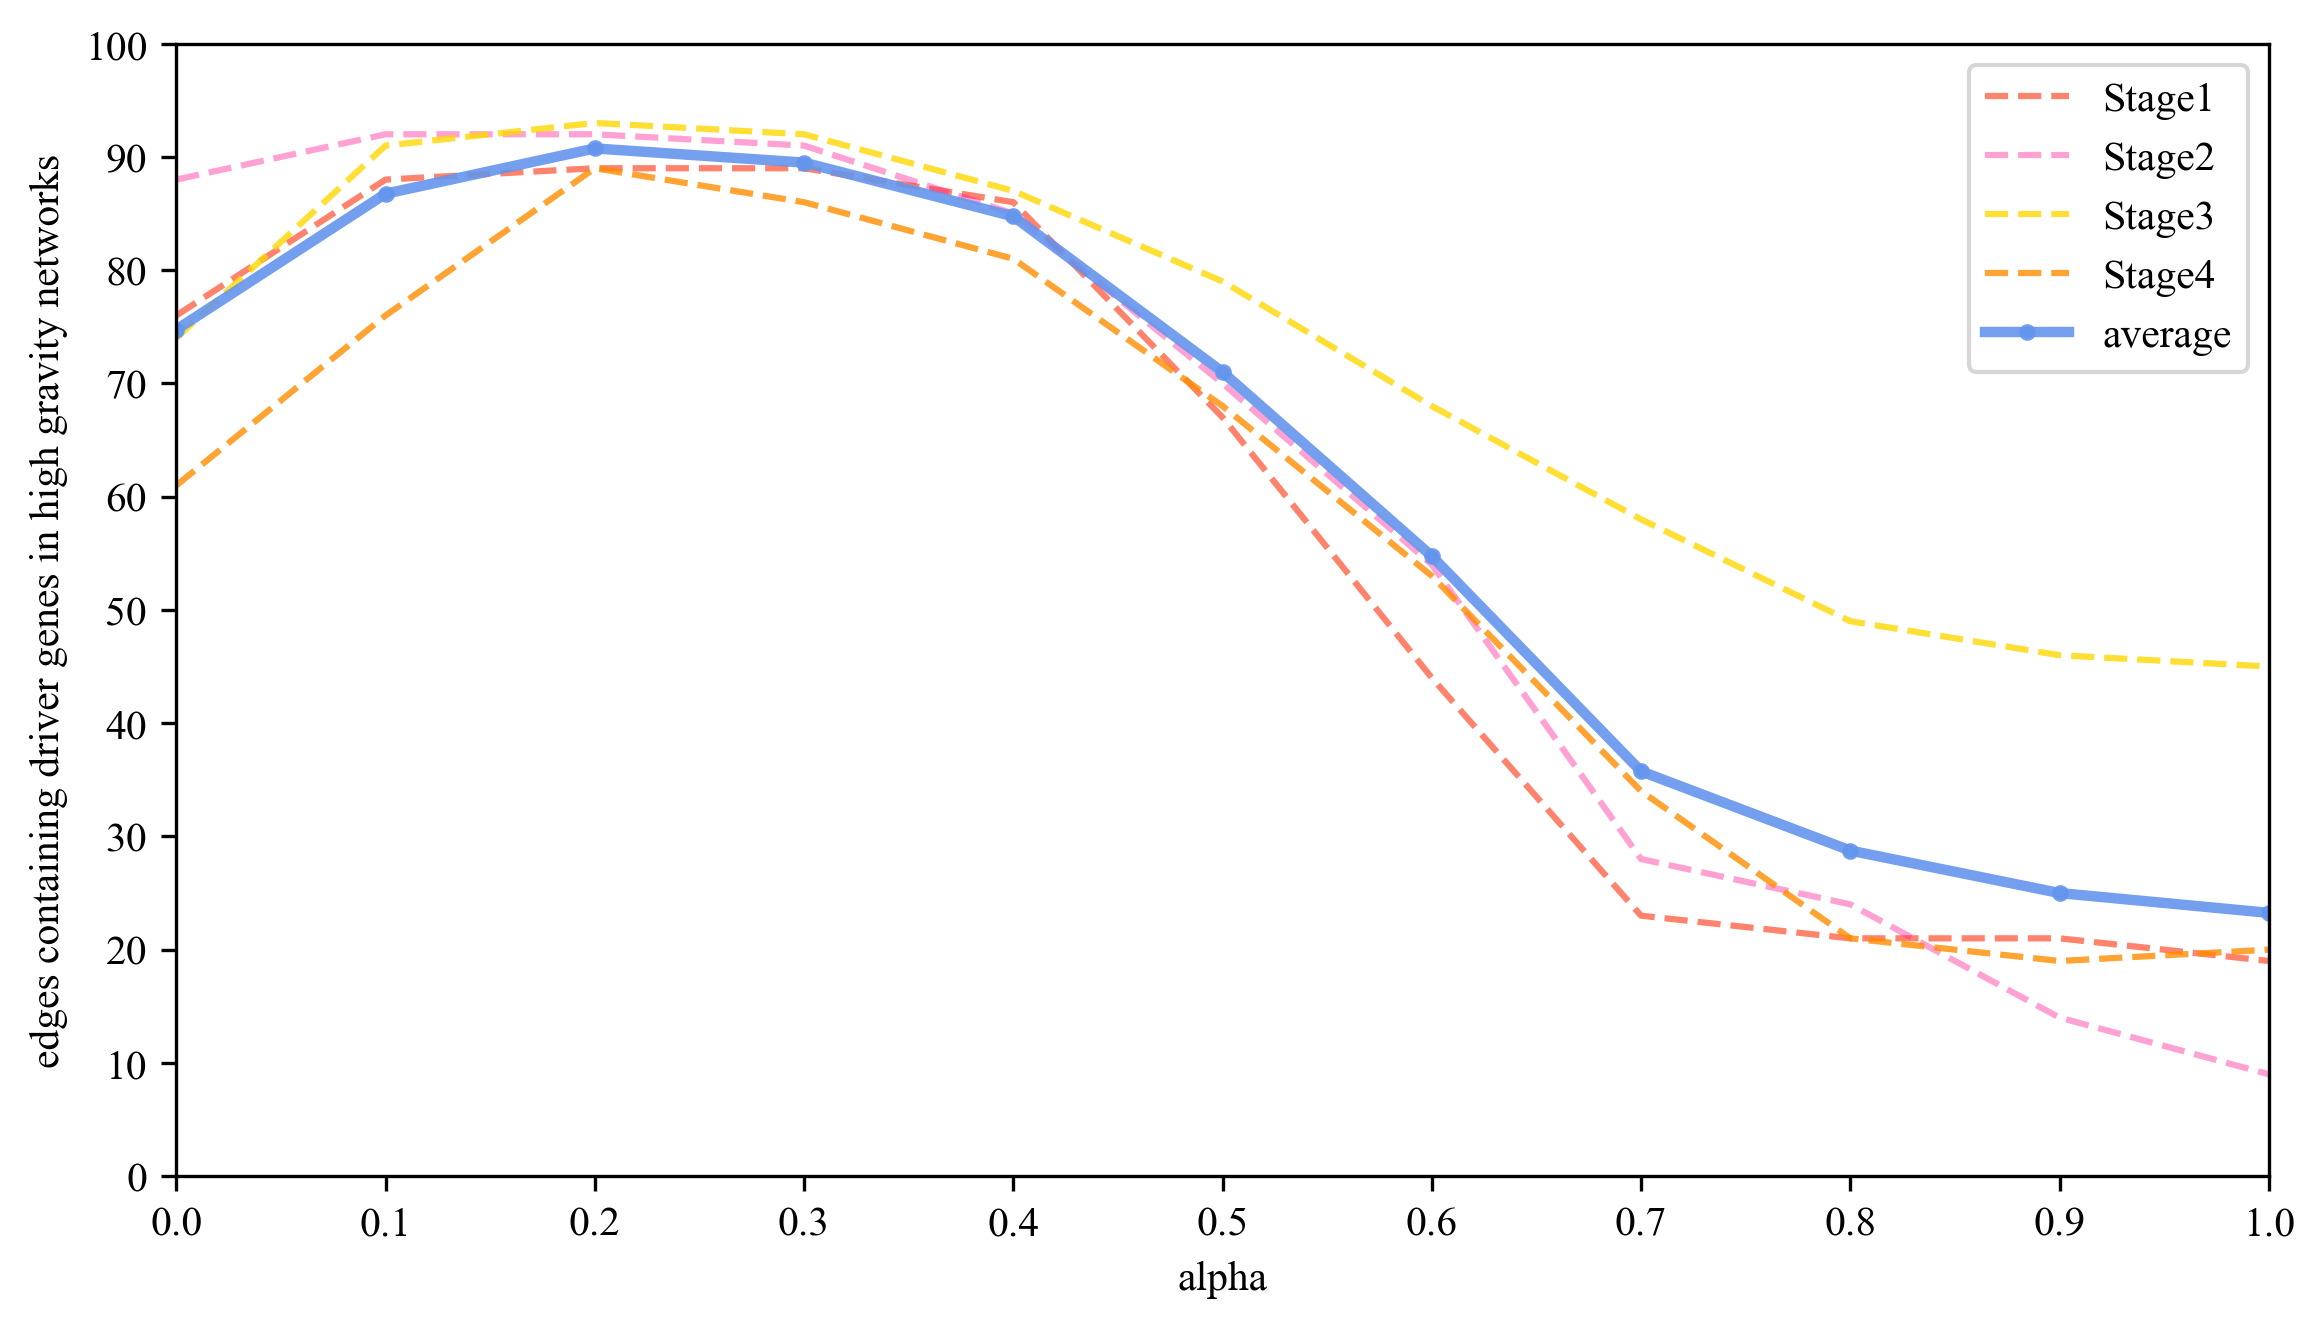

[74.75, 86.75, 90.75, 89.5, 84.75, 71.0, 54.75, 35.75, 28.75, 25.0, 23.25]


In [112]:
# make plot
x = np.arange(0,1.1,0.1)
y1 = [76,88,89,89,86,67,44,23,21,21,19]
y2 = [88,92,92,91,85,70,54,28,24,14,9]
y3 = [74,91,93,92,87,79,68,58,49,46,45]
y4 = [61,76,89,86,81,68,53,34,21,19,20]
y_avg = []
for i in range(len(y1)):
    y_avg.append((y1[i]+y2[i]+y3[i]+y4[i])/4)
plt.rc('font',family='Times New Roman')
plt.figure(figsize=(9,5),dpi=300)
plt.plot(x,y1,label = "Stage1",linestyle='--',alpha=0.8,linewidth=1.5,c="tomato")
plt.plot(x,y2,label = "Stage2",linestyle='--',alpha=0.4,linewidth=1.5,c="deeppink")
plt.plot(x,y3,label = "Stage3",linestyle='--',alpha=0.8,linewidth=1.5,c="gold")
plt.plot(x,y4,label = "Stage4",linestyle='--',alpha=0.8,linewidth=1.5,c="darkorange")
plt.plot(x,y_avg,marker=".",label = "average",alpha=0.9,linewidth=2.5,c="cornflowerblue")
plt.xlabel("alpha")
plt.ylabel("edges containing driver genes in high gravity networks")
plt.legend()
plt.xlim(0,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.show()
print(y_avg)

### Part3: use the best alpha to calculate the gravity and other information

- using alpha=0.2 to intergrate

In [129]:
df_gl_S4,df_ei_S4 = initial(0.2,df_gl_S4,df_ei_S4,100)
df_ei_S4 = df_ei_S4.reset_index(drop=True).loc[::-1].reset_index(drop=True)
df_gl_S4.reset_index(drop=True,inplace=True)
df_ei_S4.to_csv(r'S4_ei_result.csv',index=False)
df_gl_S4.to_csv(r'S4_gl_result.csv',index=False)

alpha=0.2
按driver基因对边分类：
89 37.922961608112786 0.42610069222598634
11 4.548135020257645 0.4134668200234222
按DNA修复基因对边分类：
55 23.031768467380815 0.41875942667965116
45 19.439328160989636 0.4319850702442141
按CRF染色质因子对边分类：
18 6.674305515286195 0.3707947508492331
82 35.796791113084254 0.43654623308639334
按必要基因对边分类：
21 10.377870254994193 0.4941842978568663
79 32.09322637337626 0.4062433718148894
Top100sumG共识别出driver：27个，识别出DNA-repaire6个，识别出CRF14个，识别出必要基因32个
Top100avgG共识别出driver：11个，识别出DNA-repaire2个，识别出CRF20个，识别出必要基因45个



In [130]:
df_gl_S3,df_ei_S3 = initial(0.2,df_gl_S3,df_ei_S3,100)
df_ei_S3 = df_ei_S3.reset_index(drop=True).loc[::-1].reset_index(drop=True)
df_gl_S3.reset_index(drop=True,inplace=True)
df_ei_S3.to_csv(r'S3_ei_result.csv',index=False)
df_gl_S3.to_csv(r'S3_gl_result.csv',index=False)

alpha=0.2
按driver基因对边分类：
93 42.405927565903 0.4559777157623978
7 2.724625138097361 0.3892321625853373
按DNA修复基因对边分类：
61 29.733435945668347 0.4874333761584975
39 15.397116758331999 0.39479786559825636
按CRF染色质因子对边分类：
10 5.001044546040167 0.5001044546040168
90 40.129508157960174 0.44588342397733527
按必要基因对边分类：
21 8.995853593720609 0.42837398065336235
79 36.13469911027974 0.45740125456050307
Top100sumG共识别出driver：29个，识别出DNA-repaire6个，识别出CRF12个，识别出必要基因32个
Top100avgG共识别出driver：27个，识别出DNA-repaire4个，识别出CRF19个，识别出必要基因43个



In [133]:
df_gl_S2 = pd.read_csv(r'S2_gl_result.csv')
df_gl_S2,df_ei_S2 = initial(0.2,df_gl_S2,df_ei_S2,100)
df_ei_S2 = df_ei_S2.reset_index(drop=True).loc[::-1].reset_index(drop=True)
df_gl_S2.reset_index(drop=True,inplace=True)
df_ei_S2.to_csv(r'S2_ei_result.csv',index=False)
df_gl_S2.to_csv(r'S2_gl_result.csv',index=False)

alpha=0.2
按driver基因对边分类：
92 53.22335048499039 0.5785146791846781
8 3.185255660810763 0.3981569576013454
按DNA修复基因对边分类：
58 34.946770210064784 0.6025305208631859
42 21.46183593573638 0.5109960937080091
按CRF染色质因子对边分类：
11 7.254279679178727 0.6594799708344298
89 49.154326466622436 0.5522958029957578
按必要基因对边分类：
16 9.614010893396252 0.6008756808372657
84 46.7945952524049 0.5570785149095822
Top100sumG共识别出driver：31个，识别出DNA-repaire4个，识别出CRF12个，识别出必要基因31个
Top100avgG共识别出driver：33个，识别出DNA-repaire5个，识别出CRF19个，识别出必要基因51个



In [135]:
df_gl_S1 = pd.read_csv(r'S1_result_0511_v1.csv')
df_gl_S1,df_ei_S1 = initial(0.2,df_gl_S1,df_ei_S1,100)
df_ei_S1 = df_ei_S1.reset_index(drop=True).loc[::-1].reset_index(drop=True)
df_gl_S1.reset_index(drop=True,inplace=True)
df_ei_S1.to_csv(r'S1_ei_result.csv',index=False)
df_gl_S1.to_csv(r'S1_gl_result.csv',index=False)

alpha=0.2
按driver基因对边分类：
89 33.97304902121942 0.3817196519238137
11 3.9914744110632236 0.3628613100966567
按DNA修复基因对边分类：
56 19.86983316608823 0.3548184493944327
44 18.09469026619441 0.41124296059532744
按CRF染色质因子对边分类：
10 3.645454072417684 0.36454540724176837
90 34.31906935986496 0.38132299288738847
按必要基因对边分类：
16 6.632326964246953 0.4145204352654346
84 31.332196468035683 0.3730023389051867
Top100sumG共识别出driver：28个，识别出DNA-repaire5个，识别出CRF12个，识别出必要基因36个
Top100avgG共识别出driver：11个，识别出DNA-repaire1个，识别出CRF13个，识别出必要基因47个



In [144]:
gr = list(df_ei_S1['gravity'])
for i in range(len(gr)):
    gr[i] = str(gr[i])[:5]
df_ei_S1['gravity'] = gr

gr = list(df_ei_S2['gravity'])
for i in range(len(gr)):
    gr[i] = str(gr[i])[:5]
df_ei_S2['gravity'] = gr

gr = list(df_ei_S3['gravity'])
for i in range(len(gr)):
    gr[i] = str(gr[i])[:5]
df_ei_S3['gravity'] = gr

gr = list(df_ei_S4['gravity'])
for i in range(len(gr)):
    gr[i] = str(gr[i])[:5]
df_ei_S4['gravity'] = gr

store edge list

In [145]:
df_ei_S1[:100].to_csv('visual/S1_visual.csv',index=False)
df_ei_S2[:100].to_csv('visual/S2_visual.csv',index=False)
df_ei_S3[:100].to_csv('visual/S3_visual.csv',index=False)
df_ei_S4[:100].to_csv('visual/S4_visual.csv',index=False)

In [94]:
driver_list = pd.read_csv(r'canonical_drivers.txt')
driver_list = list(driver_list['driver gene symbol'])
crf_list = pd.read_csv(r'CRF染色质调节因子(去重前).txt')
crf_list = list(crf_list['CRF_gene_symbol'])
eg = pd.read_csv(r'OEGG_EssentialGenes.txt',sep="\t")
essential_gene_list = list(eg['gene'])
drl = pd.read_csv(r'DNA修复gene.txt',sep="\t")
drl = list(drl['Protein_name'])

add node information on genes

In [151]:
df_gl_S1 = pd.concat([df_gl_S1,pd.DataFrame(columns=['is driver','is CRF','is repair','is eg'])])
for i in range(len(df_gl_S1)):
    if df_gl_S1['gene_symbol'].loc[i] in driver_list:
        df_gl_S1['is driver'].loc[i] = 1
    if df_gl_S1['gene_symbol'].loc[i] not in driver_list:
        df_gl_S1['is driver'].loc[i] = 0
    if df_gl_S1['gene_symbol'].loc[i] in crf_list:
        df_gl_S1['is CRF'].loc[i] = 1
    if df_gl_S1['gene_symbol'].loc[i] not in crf_list:
        df_gl_S1['is CRF'].loc[i] = 0
    if df_gl_S1['gene_symbol'].loc[i] in drl:
        df_gl_S1['is repair'].loc[i] = 1
    if df_gl_S1['gene_symbol'].loc[i] not in drl:
        df_gl_S1['is repair'].loc[i] = 0
    if df_gl_S1['gene_symbol'].loc[i] in essential_gene_list:
        df_gl_S1['is eg'].loc[i] = 1
    if df_gl_S1['gene_symbol'].loc[i] not in essential_gene_list:
        df_gl_S1['is eg'].loc[i] = 0
        
df_gl_S2 = pd.concat([df_gl_S2,pd.DataFrame(columns=['is driver','is CRF','is repair','is eg'])])
for i in range(len(df_gl_S2)):
    if df_gl_S2['gene_symbol'].loc[i] in driver_list:
        df_gl_S2['is driver'].loc[i] = 1
    if df_gl_S2['gene_symbol'].loc[i] not in driver_list:
        df_gl_S2['is driver'].loc[i] = 0
    if df_gl_S2['gene_symbol'].loc[i] in crf_list:
        df_gl_S2['is CRF'].loc[i] = 1
    if df_gl_S2['gene_symbol'].loc[i] not in crf_list:
        df_gl_S2['is CRF'].loc[i] = 0
    if df_gl_S2['gene_symbol'].loc[i] in drl:
        df_gl_S2['is repair'].loc[i] = 1
    if df_gl_S2['gene_symbol'].loc[i] not in drl:
        df_gl_S2['is repair'].loc[i] = 0
    if df_gl_S2['gene_symbol'].loc[i] in essential_gene_list:
        df_gl_S2['is eg'].loc[i] = 1
    if df_gl_S2['gene_symbol'].loc[i] not in essential_gene_list:
        df_gl_S2['is eg'].loc[i] = 0
    
df_gl_S3 = pd.concat([df_gl_S3,pd.DataFrame(columns=['is driver','is CRF','is repair','is eg'])])
for i in range(len(df_gl_S3)):
    if df_gl_S3['gene_symbol'].loc[i] in driver_list:
        df_gl_S3['is driver'].loc[i] = 1
    if df_gl_S3['gene_symbol'].loc[i] not in driver_list:
        df_gl_S3['is driver'].loc[i] = 0
    if df_gl_S3['gene_symbol'].loc[i] in crf_list:
        df_gl_S3['is CRF'].loc[i] = 1
    if df_gl_S3['gene_symbol'].loc[i] not in crf_list:
        df_gl_S3['is CRF'].loc[i] = 0
    if df_gl_S3['gene_symbol'].loc[i] in drl:
        df_gl_S3['is repair'].loc[i] = 1
    if df_gl_S3['gene_symbol'].loc[i] not in drl:
        df_gl_S3['is repair'].loc[i] = 0
    if df_gl_S3['gene_symbol'].loc[i] in essential_gene_list:
        df_gl_S3['is eg'].loc[i] = 1
    if df_gl_S3['gene_symbol'].loc[i] not in essential_gene_list:
        df_gl_S3['is eg'].loc[i] = 0
    
df_gl_S4 = pd.concat([df_gl_S4,pd.DataFrame(columns=['is driver','is CRF','is repair','is eg'])])
for i in range(len(df_gl_S4)):
    if df_gl_S4['gene_symbol'].loc[i] in driver_list:
        df_gl_S4['is driver'].loc[i] = 1
    if df_gl_S4['gene_symbol'].loc[i] not in driver_list:
        df_gl_S4['is driver'].loc[i] = 0
    if df_gl_S4['gene_symbol'].loc[i] in crf_list:
        df_gl_S4['is CRF'].loc[i] = 1
    if df_gl_S4['gene_symbol'].loc[i] not in crf_list:
        df_gl_S4['is CRF'].loc[i] = 0
    if df_gl_S4['gene_symbol'].loc[i] in drl:
        df_gl_S4['is repair'].loc[i] = 1
    if df_gl_S4['gene_symbol'].loc[i] not in drl:
        df_gl_S4['is repair'].loc[i] = 0
    if df_gl_S4['gene_symbol'].loc[i] in essential_gene_list:
        df_gl_S4['is eg'].loc[i] = 1
    if df_gl_S4['gene_symbol'].loc[i] not in essential_gene_list:
        df_gl_S4['is eg'].loc[i] = 0

store gene list

In [157]:
df_gl_S1.to_csv(r'S1_gl_result.csv',index=False)
df_gl_S2.to_csv(r'S2_gl_result.csv',index=False)
df_gl_S3.to_csv(r'S3_gl_result.csv',index=False)
df_gl_S4.to_csv(r'S4_gl_result.csv',index=False)